# Full FEE

### Detailed model of the PMT plane front-end electronics

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from DBLR_cal import BLRc
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.style.use('ggplot')

In [5]:
import system_of_units as units

In [6]:
import time

In [7]:
import FEE as FE

In [8]:
import tables

In [9]:
import mplFunctions as mpl
import wfmFunctions as wfm

In [10]:
import fit_library as fit

## Revised on:

In [11]:
print(time.strftime("%d/%m/%Y"))

01/11/2016


In [12]:
print(time.strftime("%H:%M:%S"))

20:19:29


In [13]:
!pep8 ../Sierpe/FEE.py

In [14]:
!pyflakes ../Sierpe/FEE.py

### SPE

Class SPE models a single photoelectron in the PMT (represents a delta by a narrow trapezoid)

#### SPE instance

In [15]:
spe = FE.SPE()

In [16]:
spe


        (PMT gain = 4.5e+06, amplitude = 1.2e+02 muA
         slope =  5.00 ns, flat =  1.00 ns)
        

In [17]:
assert abs(spe.pmt_gain - FE.PMT_GAIN) < 0.01, 'Nominal pmt gain must be {}'.format(FE.PMT_GAIN)
assert abs(spe.A/units.muA - 120.163) < 0.01, 'spe amplitude must be 120 muA is {}'.format(spe.A/units.muA)

### SPE functions

1. *spe_pulse(spe,t0=100*units.ns, tmax=1e+6*units.ns, time_step=1*units.ns)*: generates a spe pulse between t0 and tmax in units of t_step

2. *spe_pulse_train(spe,signal_start=2000*units.ns, signal_length=5000*units.ns, daq_window = 20*units.mus, time_step=1*units.ns)*:  generates a train of spe pulses between signal_start and (start+ length), in the window daq_window
   
3. *spe_pulse_from_vector(spe,cnt)*: Returns a train of SPE pulses corresponding to vector cnt

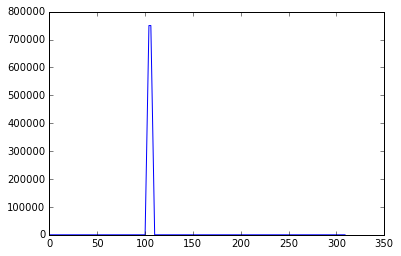

In [18]:
plt.plot(FE.spe_pulse(spe,t0=100*units.ns, tmax=300*units.ns))

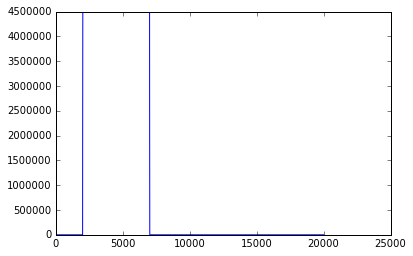

In [19]:
plt.plot(FE.spe_pulse_train(spe,signal_start=2000*units.ns,signal_length=5000*units.ns, daq_window=20*units.mus))

In [20]:
cnt = np.random.poisson(5, 10000)

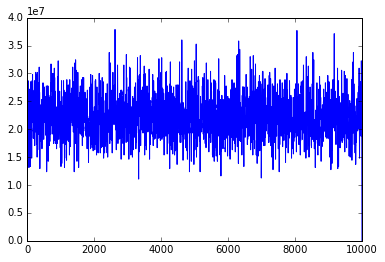

In [21]:
plt.plot(FE.spe_pulse_from_vector(spe,cnt))

## Full FEE model

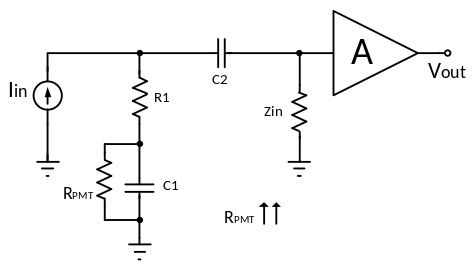

In [22]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "FEE_PMT.png")

## ==== NOISE MODEL (PMT AND FEE are combined) ====

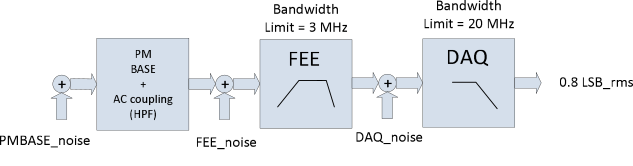

In [23]:
PATH = "./Rpar_Images/"; Image(filename = PATH + "NOISE.png")

$$ GAIN=FEE_{GAIN} \times DAQ_{GAIN} $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = v_{DAQnoise}^{2}(out) + v_{FEE+PMBnoise}^{2}(out) $$
$$ $$
$$ vo_{TOTAL_{noise}}^{2} = \int_{0}^{BW=3MHz}{v_{FEE+PMBnoise}^{2} \times {\lvert}GAIN.H(jw){\rvert}^2}  + \int_{0}^{BW=20MHz}{v_{DAQnoise}^{2} \times {\lvert}DAQ_{GAIN}.H(jw){\rvert}^2} $$
$$ $$
$$ vo_{TOTAL_{noise(rms)}} = \sqrt{vo_{TOTAL_{noise}}^{2}} = 0.76LSB_{rms}$$

### MEASURED NOISE 
$$ v_{DAQnoise}^{2}(out) = 0.64 ~LSB_{rms} = 0.3136 ~mV_{rms} $$
$$ v_{FEE+PMBnoise}^{2}(out) = 0.41 ~LSB_{rms} = ~0.2009 ~mV_{rms} $$

### Globals

In [24]:
print('GAIN = {} ohm, DAQ GAIN = {} LSB = {} mV'.format(FE.MEASURED_GAIN/units.ohm,
                                                        FE.DAQ_GAIN,
                                                        FE.LSB/units.mV))

GAIN = 582.237 ohm, DAQ GAIN = 1.25 LSB = 0.390625 mV


In [25]:
print('NOISE_I = {} muA'.format(FE.NOISE_I/units.muA))  # noise equivalent to 1 LSB in units of current

NOISE_I = 0.53672301829 muA


In [26]:
assert abs(FE.MEASURED_GAIN/units.ohm - 582.237) < 0.01, 'Nominal measured gain must be 582.237 ohm'
assert FE.DAQ_GAIN == 1.25, 'DAQ gain must be 1.25'
assert abs(FE.LSB/units.mV - 0.3906) < 0.01, 'LSB must be 0.390625 mV'
assert abs(FE.NOISE_I/units.muA - 0.5367) < 0.01, 'NOISE_I must be 0.53672301829 muA'

### FEE instance (no noise)

In [27]:
feep = FE.FEE(noise_FEEPMB_rms=0*units.mA, noise_DAQ_rms=0)

In [28]:
feep


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.00 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =       0
        )
        

In [29]:
assert abs(feep.C1 - FE.C1) < 0.01, 'default C1 must be {}'.format(FE.C1)

### FEE functions

1. i_to_adc(fee): conversion from current to adc counts
2. i_to_v(fee): conversion from current to voltage
3. noise_adc(fee): noise outuput in adc counts

In [30]:
FE.i_to_adc(feep)*spe.A   #single photoelectron amplitude in ADC counts

179.10660904074427

In [31]:
FE.i_to_v(feep)*spe.A/units.mV  #spe in mV

69.96351915654073

In [32]:
assert abs(FE.i_to_adc(feep)*spe.A - 179.1066) < 0.01, 'single photoelectron amplitude in ADC counts must be 179.1066'
assert abs(FE.i_to_v(feep)*spe.A/units.mV - 69.96) < 0.01, 'single photoelectron in mV must be 69.96'

### Deconvolution algorithm

The simplest version of the deconvolution algorithm (no noise)

In [33]:
def deconv_simple(signal,coef):
    """
    Deconvolution of the fine-grained fee signal (no DAQ)
    no noise
    using true start and end of signals
    """

    acum = np.zeros(len(signal))

    acum[0]=coef*signal[0]
    for n in np.arange(1,len(signal)):
        acum[n] = acum[n-1] + signal[n]

    signal_r = signal + coef*acum

    return signal_r, acum

## FEE filters

#### filter_fee : This function gives the coefficients needed to filter the input signal and emulate the effect of FEE
#### NB: a is adimensional, but b is given in ohms (it includes gain). Thus the output of the filter will be in voltage (input in current)

In [34]:
b,a = FE.filter_fee(feep)

In [35]:
print('filter parameters: a = {} b = {} ohm'.format(a, b/units.ohm))

filter parameters: a = [ 1.         -1.61087863  1.09765171 -0.78293344  0.31493115 -0.02845585
  0.0108042 ] b = [  1.05834516e+01   4.23338687e+01   5.29175691e+01   6.22138897e-04
  -5.29166359e+01  -4.23334954e+01  -1.05833894e+01] ohm


In [36]:
print("f_sample = {} Mhz".format(feep.f_sample/units.MHZ))

f_sample = 40.0 Mhz


In [37]:
def plot_filter(a,b, size_x=10, size_y=10):
    """
    Plots the filter
    """
    b = b/units.ohm
    # Freqz outputs rad/sample (desnorm ===> f_sample/(2*pi))
    w, h = signal.freqz(b, a, worN=np.logspace(-6.5,0.4,40000)) 
    fig = plt.figure(figsize=(size_x, size_y))
    ax1 = fig.add_subplot(111)
    plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), 20 * np.log10(abs(h)))
    plt.title('FEE_PMT frequency response')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Amplitude [dB]')
    plt.margins(0, 0.1)
    plt.grid(which='both', axis='both')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    plt.semilogx(w*(feep.f_sample/units.hertz)/(2*np.pi), angles,'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')

    plt.show()

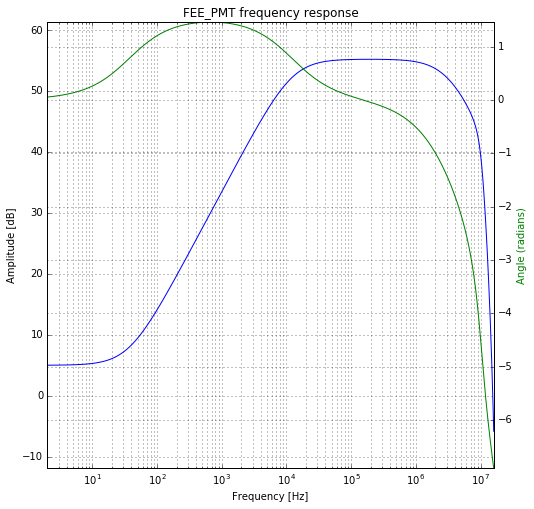

In [38]:
plot_filter(a,b,size_x=8, size_y=8)

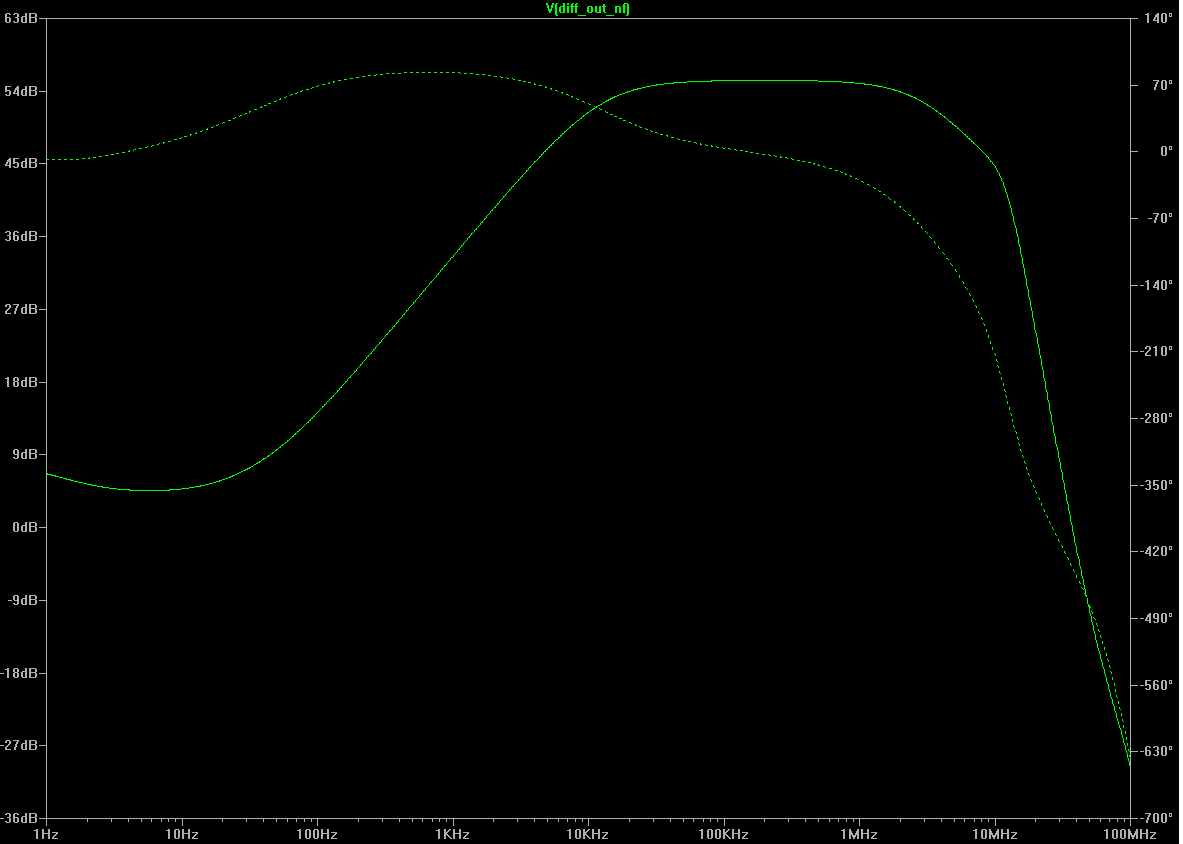

In [39]:
Image(filename = PATH + "FEE_PMT_freq_response_simulated_spice.png")

#### MATCH!!!   --VERY CLOSE TO THE SPICE SIMULATED ONE--

### =======   TEST WITHOUT NOISE   ========

In [40]:
def signal_i_th():
    """
    generates a "theoretical" current signal (signal_i)
    """
    return np.concatenate((np.zeros(1000),np.linspace(0,0.5,2000),np.linspace(0.5,0,1000),
                            np.linspace(0,1,1000),np.linspace(1,0,2000),
                            np.linspace(0,1,2000),np.linspace(1,0,2000),
                            np.zeros(20000)),axis=0)*units.mA

In [41]:
signal_i = signal_i_th()

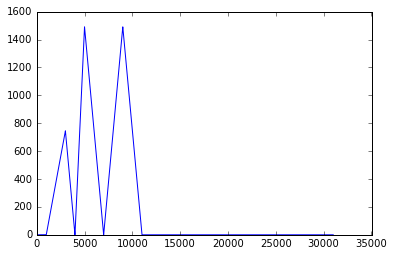

In [42]:
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))   #plot input signal in adc counts

### Effect of electronics 

1. Implemented by the funtion signal_v_fee(feep, signal_i), which takes a current signal and returns a voltage signal 

In [43]:
signal_out = FE.signal_v_fee(feep, signal_i)

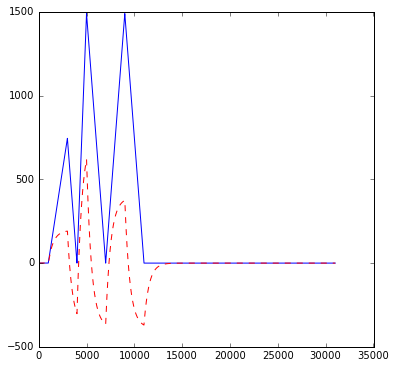

In [44]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep),'r--', linewidth=1)
plt.show()

### Deconvolution

In the absence of noise, a simple deconvolution (deconv_simple) is sufficient. 

In [45]:
print('deconvolution coefficient = {}'.format(feep.freq_LHPFd*np.pi))

deconvolution coefficient = 0.00192400951255


In [46]:
signal_r, acum = deconv_simple(signal_out*FE.v_to_adc(feep),coef=feep.freq_LHPFd*np.pi)

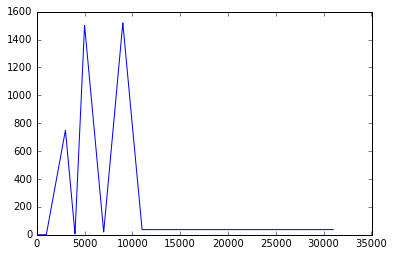

In [47]:
plt.plot(signal_r)   # in adc counts

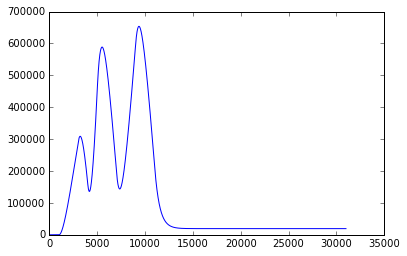

In [48]:
plt.plot(acum)  #the value of the accumulator

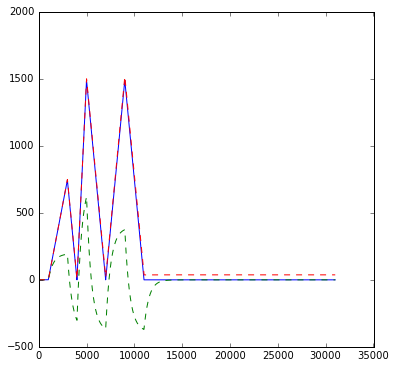

In [49]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep),'g--', linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r,'r--', linewidth=1)
plt.show()

#### NB: The deconvolution is good, but the recovered function shows a pedestal above the input function, which needs to be removed.

### Effect of pedestal in energy recovery

In [50]:
energy_mea=np.sum(signal_r[1000:11000])
energy_in=np.sum(signal_i*FE.i_to_adc(feep))
print('Input Energy = {}'.format(energy_in))
print('Reconstructed Energy = {}'.format(energy_mea))
print('Error in Energy Computation (%) = {}'.format((energy_in-energy_mea)/energy_in*100))

Input Energy = 6334738.56
Reconstructed Energy = 6499097.56906
Error in Energy Computation (%) = -2.5945665713


## DECONVOLUTION USING CLEANING FILTER + BLR

#### Cleaning the pedestal 

this is achieved by function *signal_v_clean(feep, signal_v)* which takes the signal produced by the convolution and removes the pedestal. 

In [51]:
signal_out_cf = FE.signal_v_clean(feep, signal_out)

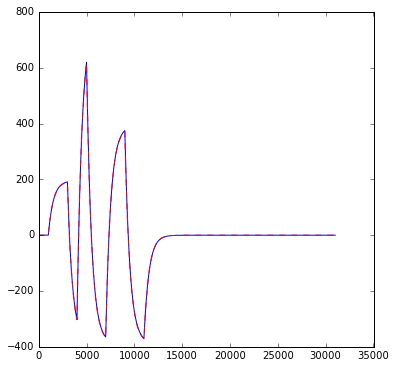

In [52]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_out*FE.v_to_adc(feep), linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_out_cf*FE.v_to_adc(feep),'r--', linewidth=1)
plt.show()

#### NB: The cleaned signal appears indistinguishible from the convoluted signal. However, when the signal is recovered the pedestal dissappears

In [53]:
signal_r2, acum = deconv_simple(signal_out_cf*FE.v_to_adc(feep),coef=feep.freq_LHPFd*np.pi)

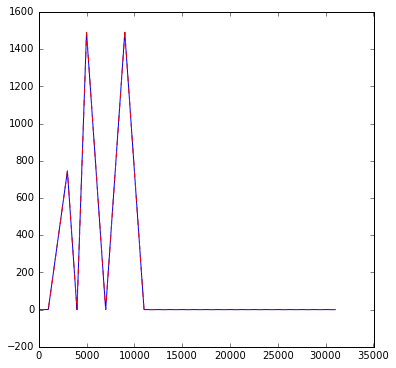

In [54]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_r2,'r--', linewidth=1)
plt.show()

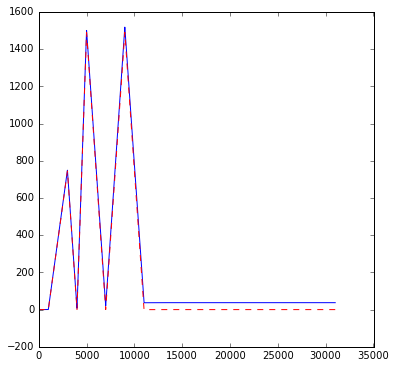

In [55]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_r, linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_r2,'r--', linewidth=1)
plt.show()

In [56]:
energy_mea2=np.sum(signal_r2[1000:11000])
energy_in2=np.sum(signal_i*FE.i_to_adc(feep))
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6334918.78314
Error in Energy Computation (%) = -0.00284499725187


## ======  TEST WITH NOISE and DAQ EFFECT ======= 

In [57]:
print('GAIN = {} ohm, DAQ GAIN = {} LSB = {} mV'.format(FE.MEASURED_GAIN/units.ohm,
                                                        FE.DAQ_GAIN,
                                                        FE.LSB/units.mV))

GAIN = 582.237 ohm, DAQ GAIN = 1.25 LSB = 0.390625 mV


In [58]:
print('LSB/(MEASURED_GAIN*DAQ_GAIN) = {} muA'.format(FE.NOISE_I/units.muA))

LSB/(MEASURED_GAIN*DAQ_GAIN) = 0.53672301829 muA


In [59]:
feepN = FE.FEE(noise_FEEPMB_rms=1*FE.NOISE_I,noise_DAQ_rms=FE.NOISE_DAQ)
feepN


        (C1 =  2714.0 nf,
         C2 =     8.0 nf,
         R1 =  1567.0 ohm,
         Zin =    62.0 ohm,
         gain =   582.2 ohm,
         f_sample =    40.0 MHZ,
         freq_LHPF =   12.25 kHz,
         freq_LPF1 =    3.00 MHZ,
         freq_LPF2 =   10.00 MHZ,
         freq_LHPFd =  0.00061,
         freq_LPF1d =    0.15,
         freq_LPF2d =    0.50,
         noise_FEEPMB_rms =    0.54 muA,
         LSB =    0.39 mV,
         volts to adc = 0.00039,
         DAQnoise_rms =    0.31
        )
        

In [60]:
signal_outn = FE.signal_v_fee(feepN, signal_i)  #this time with effect of noise

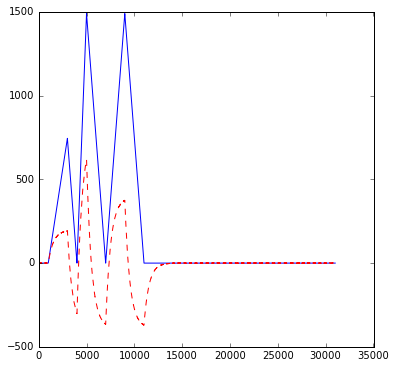

In [61]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feepN))
plt.plot(range(0,np.size(signal_i),1),signal_outn*FE.v_to_adc(feepN),'r--', linewidth=1)
plt.show()

In [62]:
print "Out Noise FEE (LSB_rms) =",np.std(signal_outn[25000:26000]*FE.v_to_adc(feepN),ddof=1)

Out Noise FEE (LSB_rms) = 0.34903094042


#### NB: the nominal noise for FEE + PMT is 0.2 adc counts. One can tune the value of the noise up, but the order of magnitude is correct

### Now add the DAQ contribution

In [63]:
signal_outnd = FE.noise_adc(feepN, signal_outn)

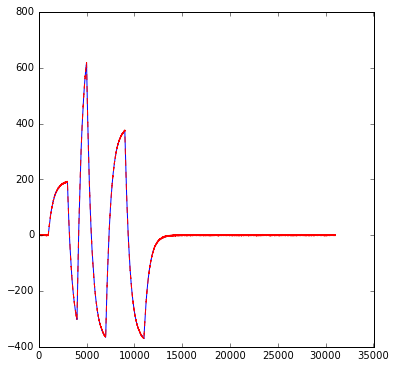

In [64]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_outn*FE.v_to_adc(feepN), linewidth=1)
plt.plot(range(0,np.size(signal_i),1),signal_outnd*FE.v_to_adc(feepN),'r--', linewidth=1)
plt.show()

In [65]:
print "Out TOTAL out noise (LSB_rms) =",np.std(signal_outnd[25000:26000]*FE.v_to_adc(feepN),ddof=1)

Out TOTAL out noise (LSB_rms) = 0.869078077219


## Reconstruct with Cleaning Filter

In [66]:
signal_out_cf2 = FE.signal_v_clean(feepN, signal_outnd)

In [67]:
signal_r3, acum = deconv_simple(signal_out_cf2*FE.v_to_adc(feepN),coef=feepN.freq_LHPFd*np.pi)

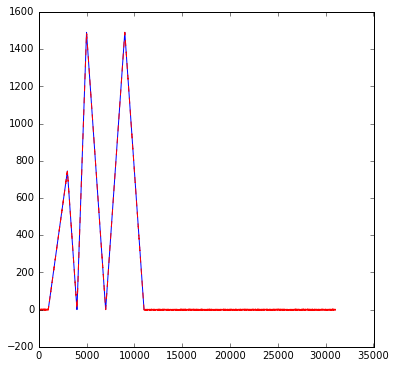

In [68]:
plt.figure(figsize=(6, 6))
plt.plot(range(0,np.size(signal_i),1),signal_i*FE.i_to_adc(feep))
plt.plot(range(0,np.size(signal_i),1),signal_r3,'r--', linewidth=1)
plt.show()

In [69]:
energy_mea2=np.sum(signal_r3[1000:11000])
energy_in2=np.sum(signal_i*FE.i_to_adc(feepN))
print('Input Energy = {}'.format(energy_in2))
print('Reconstructed Energy = {}'.format(energy_mea2))
print('Error in Energy Computation (%) = {}'.format((energy_in2-energy_mea2)/energy_in2*100))

Input Energy = 6334738.56
Reconstructed Energy = 6335290.70422
Error in Energy Computation (%) = -0.00871613269206


## Statistics

In [70]:
n = 1000
recons_a = np.zeros(n)
for i in range(0,n):
    signal_outn = FE.signal_v_fee(feepN, signal_i)   # convolution and noise FEE + PMT 
    signal_outnd = FE.noise_adc(feepN, signal_outn)  # NOISE DAQ
    signal_out_cf2 = FE.signal_v_clean(feepN, signal_outnd)  # cleaning.
    signal_r3, acum = deconv_simple(signal_out_cf2*FE.v_to_adc(feepN),coef=feepN.freq_LHPFd*np.pi)
    recons_a[i]=np.sum(signal_r3[1000:11000])

In [71]:
len(recons_a)

1000

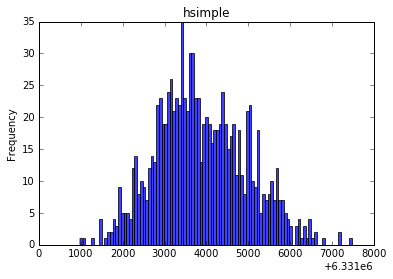

In [72]:
mpl.histo(recons_a,100)

In [73]:
LSB_DAQ = 2.0/(2**12)
SPE = 20

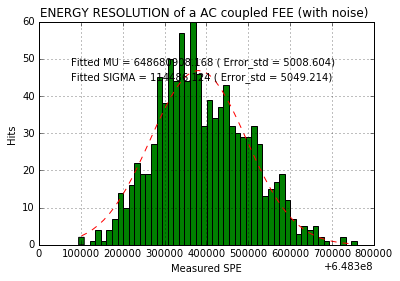

('Fitted A = ', 46.856242350030541, '( Error_std=', 1.7767955187246549, ')')
('Fitted MU = ', 648680908.16803408, '( Error_std=', 5008.6044525632851, ')')
('FItted SIGMA = ', 114486.12429541237, '( Error_std=', 5049.2138699710977, ')')
ENERGY RESOLUTION (%) =  0.0414753060721


In [74]:
[coef,error]=fit.gauss1_fit(recons_a/LSB_DAQ/SPE,'Measured SPE','Hits','ENERGY RESOLUTION of a AC coupled FEE (with noise) ',50,8,1)
print "ENERGY RESOLUTION (%) = ",(coef[2]/coef[1])*100*2.35